In [1]:
import os
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat

#IMPORTANT TO CHANGE
# Change the working directory to where load_data.py is located
os.chdir('/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project3/ECE5242Proj3-train')
from load_data import get_encoder, get_lidar, get_imu

#IMPORTANT TO CHANGE
# Change the working directory to where MapUtils_fclad is located
os.chdir('/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project3/ECE5242Proj3-train/MapUtilsCython')
from MapUtils_fclad import getMapCellsFromRay_fclad

# # Change the working directory to where MapUtils is located
# os.chdir('/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project3/ECE5242Proj3-train/MapUtils')
# from MapUtils import getMapCellsFromRay


# **Map 20**

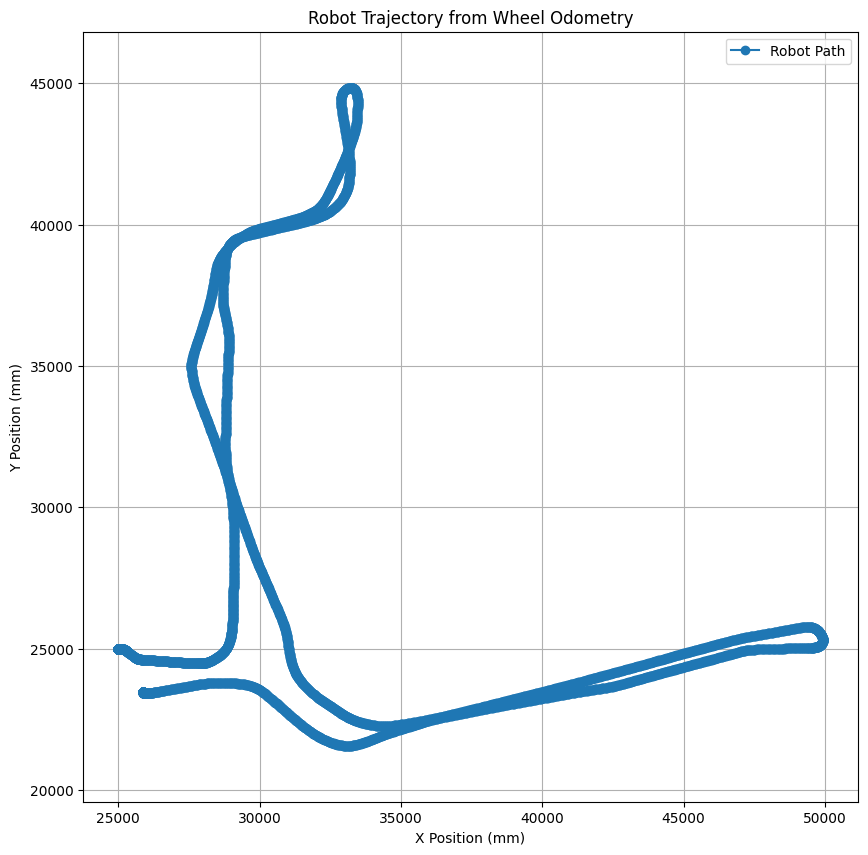

In [25]:
#### CELL 1 ####
# This cell is focused on tracing the path of the robot using pure wheel odometry measurements.

#IMPORTANT TO CHANGE
#change the working directory to where the data folder is
data_directory = '/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project3/ECE5242Proj3-train/data'

FL, FR, RL, RR, encoder_ts = get_encoder(data_directory + '/Encoders20') #Change this to /Encoders20 or /Encoders23 to see different maps

# Constants 
wheel_diameter_mm = 254
distance_between_wheels_mm = 710 # 311.15 * 2.28
encoder_counts_per_rev = 360

# Calculate the distance per count for the encoders
distance_per_count_mm = (np.pi * wheel_diameter_mm) / encoder_counts_per_rev

# Initialize the robot's position and orientation
x_position_mm = 25000
y_position_mm = 25000
theta_radians = 0

# Lists for storing the trajectory
x_trajectory = [x_position_mm]
y_trajectory = [y_position_mm]
theta_radians_list = [theta_radians]


# Loop through encoder timestamps and calculate the robot's trajectory
for i in range(1, len(encoder_ts)):
    
    # Use left and right encoder counts to calculate distance traveled and change in orientation
    delta_FL = (FL[i]) * distance_per_count_mm
    delta_FR = (FR[i]) * distance_per_count_mm
    
    # Update the robot's orientation
    delta_theta = (delta_FR - delta_FL) / distance_between_wheels_mm
    theta_radians += delta_theta
    
    # Ensure theta is within the correct range
    # theta_radians = np.mod(theta_radians + np.pi, 2 * np.pi) - np.pi
    
    # Compute the average distance traveled and update the position
    average_distance_mm = (delta_FL + delta_FR) / 2
    x_position_mm += average_distance_mm * np.cos(theta_radians)
    y_position_mm += average_distance_mm * np.sin(theta_radians)
    
    # Add the new position to the trajectory lists
    x_trajectory.append(x_position_mm)
    y_trajectory.append(y_position_mm)
    theta_radians_list.append(theta_radians)


plt.figure(figsize=(10, 10))
plt.plot(x_trajectory, y_trajectory, label='Robot Path', marker='o')
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Robot Trajectory from Wheel Odometry')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


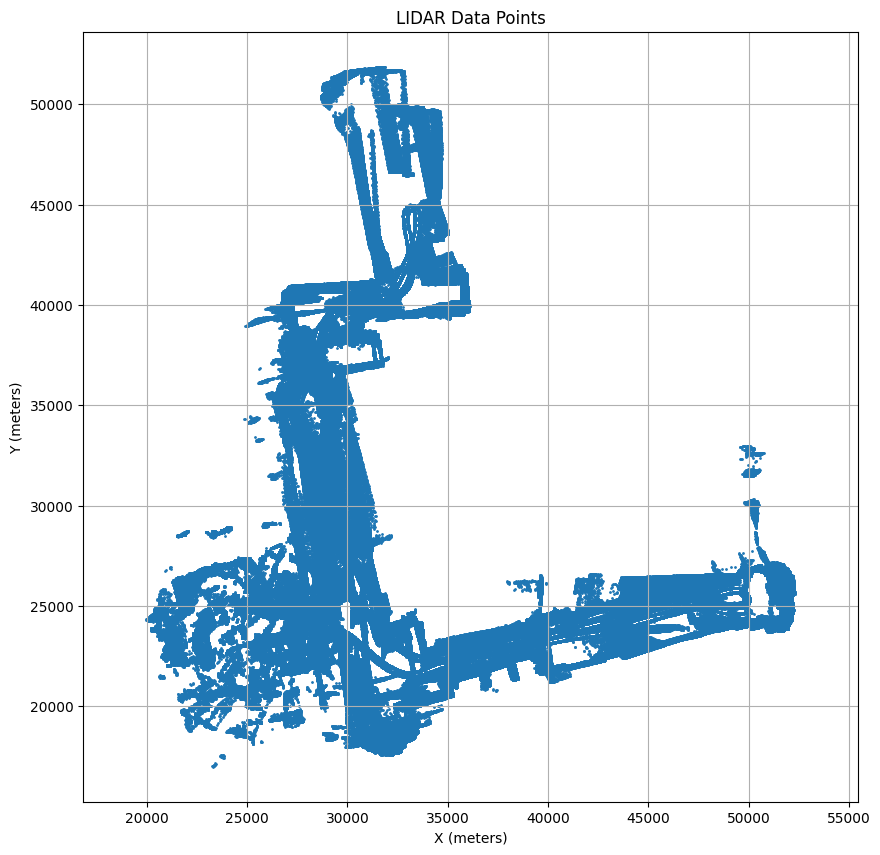

In [26]:
#### CELL 2 ####
# This cell is to scatter plot all the LIDAR Data Points in a 2D map

#IMPORTANT TO CHANGE
#change the last string to be either '/Hokuyo20' or '/Hokuyo23'
lidar_data = get_lidar(data_directory + '/Hokuyo20')

x_points = []
y_points = []


for idx, reading in enumerate(lidar_data):
    if idx >= len(x_trajectory):
        break
    angles = reading['angle']
    distances = reading['scan']
    robot_x = x_trajectory[idx]
    robot_y = y_trajectory[idx]
    robot_theta = theta_radians_list[idx]

    for angle, distance in zip(angles, distances):
        if 0 < (distance * 1000): 
            x = (distance * 1000) * np.cos(angle + robot_theta) + robot_x
            y = (distance * 1000) * np.sin(angle + robot_theta) + robot_y
            x_points.append(x)
            y_points.append(y)

plt.figure(figsize=(10, 10))
plt.scatter(x_points, y_points, s=1)  # s is the size of the points
plt.axis('equal')
plt.grid(True)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('LIDAR Data Points')
plt.show()


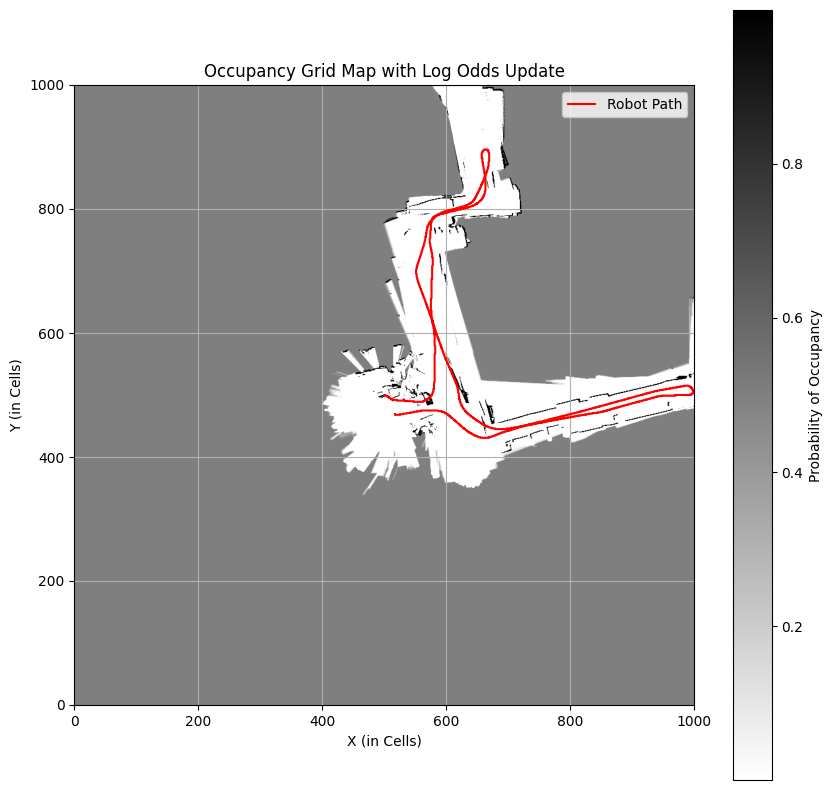

In [12]:
#### CELL 3 with log odds ####

# Warning, this cell took 37 minutes to run completely!!

# This cell plots the occupancy grid map and marks the walls, free space, and unknown in the indoor environment

LOG_ODDS_HIT = 0.7 # Positive update for hits
LOG_ODDS_MISS = -0.3  # Negative update for misses

LOG_ODDS_MAX = 10  # Cap for maximum log odds value to prevent overflow
LOG_ODDS_MIN = -10  # Cap for minimum log odds value
UNKNOWN_SPACE = 0


max_distance_mm = 50000
map_resolution_mm = 50
maxMap = int(max_distance_mm / map_resolution_mm)  # cells

debug_start_time_step = 0
debug_end_time_step = 500


# Initialization of the occupancy grid and log odds grid
occupancy_grid = np.full((maxMap, maxMap), UNKNOWN_SPACE)
log_odds_grid = np.zeros((maxMap, maxMap), dtype=float)  # Start with 0 log odds

test_end_time_step = 1000  # Set this to the number of steps you want to test

# Function to convert log odds to probabilities for visualization
def log_odds_to_prob(log_odds):
    return 1 - 1 / (1 + np.exp(log_odds))

for (reading, x_mm, y_mm, theta) in zip(
        lidar_data[:],
        x_trajectory[:],
        y_trajectory[:],
        theta_radians_list[:]):
    
    robot_x_cell = int(x_mm // map_resolution_mm)
    robot_y_cell = int(y_mm // map_resolution_mm)
    robot_theta = theta
    
     # Process each lidar measurement
    for angle, distance in zip(reading['angle'], reading['scan']):
        if 0 < distance:  # Check that distance is positive
            wall_x_mm = distance * 1000 * np.cos(angle + robot_theta)
            wall_y_mm = distance * 1000 * np.sin(angle + robot_theta)
            wall_x_cell = int((robot_x_cell * map_resolution_mm + wall_x_mm) // map_resolution_mm)
            wall_y_cell = int((robot_y_cell * map_resolution_mm + wall_y_mm) // map_resolution_mm)

            wall_x_cell_np = np.array([wall_x_cell], dtype=np.int16)
            wall_y_cell_np = np.array([wall_y_cell], dtype=np.int16)

            # Call getMapCellsFromRay_fclad with NumPy array arguments
            ray_cells = getMapCellsFromRay_fclad(
                np.array([robot_x_cell], dtype=np.int16),
                np.array([robot_y_cell], dtype=np.int16),
                wall_x_cell_np,
                wall_y_cell_np,
                maxMap
            )
            
            if ray_cells.size > 0 and ray_cells.ndim == 2:
                # Update log odds for free cells along the ray, excluding the hit cell
                free_cells = ray_cells[:, :-1]  # This should be a 2D array
                hit_cell = ray_cells[:, -1]  # This is a 1D array containing the hit cell

                for free_cell in free_cells.T:
                    if 0 <= free_cell[0] < maxMap and 0 <= free_cell[1] < maxMap:
                        log_odds_grid[free_cell[1], free_cell[0]] += LOG_ODDS_MISS

                # Update log odds for the hit cell, make sure it's within bounds
                if 0 <= hit_cell[0] < maxMap and 0 <= hit_cell[1] < maxMap:
                    log_odds_grid[hit_cell[1], hit_cell[0]] += LOG_ODDS_HIT

    # Clip log odds to avoid extreme values
    log_odds_grid = np.clip(log_odds_grid, LOG_ODDS_MIN, LOG_ODDS_MAX)

# Convert log odds to probabilities
probability_grid = log_odds_to_prob(log_odds_grid)

# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(probability_grid, cmap='gray_r', origin='lower', extent=[0, maxMap, 0, maxMap])
plt.colorbar(label='Probability of Occupancy')
plt.plot(np.array(x_trajectory) // map_resolution_mm, np.array(y_trajectory) // map_resolution_mm, 'r', label='Robot Path')
plt.xlabel('X (in Cells)')
plt.ylabel('Y (in Cells)')
plt.title('Occupancy Grid Map with Log Odds Update')
plt.grid(True)
plt.legend()
plt.show()



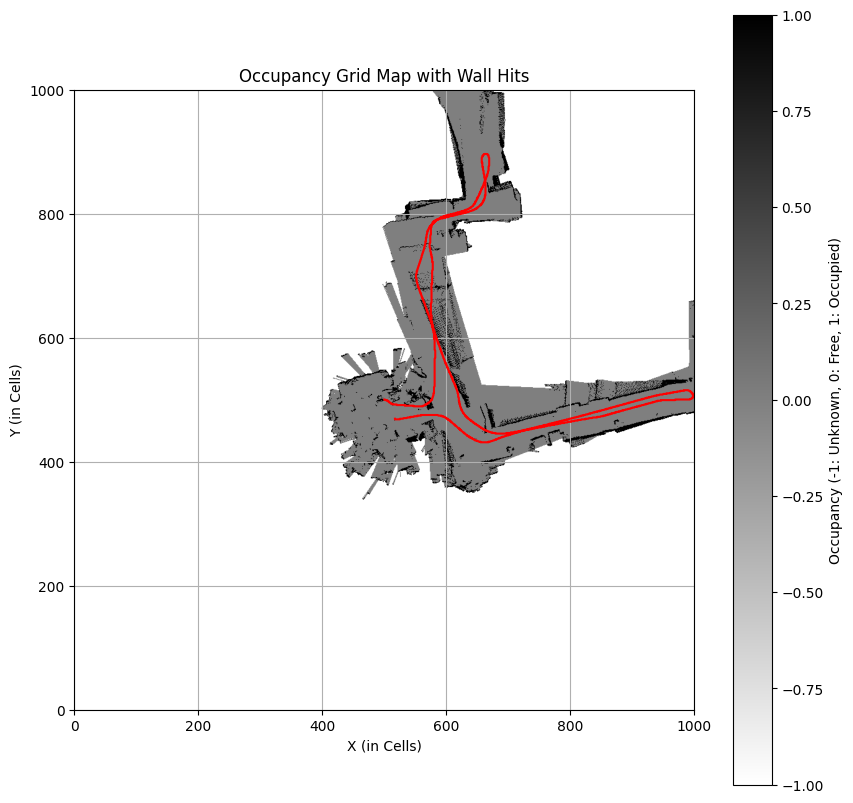

In [27]:
#### CELL 3 without log odds ####
# This cell plots the occupancy grid map and marks what are the walls, free space and unknown in the indoor environment 


FREE_SPACE = 0
OCCUPIED_SPACE = 1
UNKNOWN_SPACE = -1

max_distance_mm = 50000
map_resolution_mm = 50
maxMap = int(max_distance_mm / map_resolution_mm) #cells

occupancy_grid = np.full((maxMap, maxMap), UNKNOWN_SPACE)  

debug_start_time_step = 0
debug_end_time_step = 4200


for idx, reading in enumerate(lidar_data[:]):
    idx += debug_start_time_step

    if idx >= len(x_trajectory):
        break

    angles = reading['angle']
    distances = reading['scan'].reshape(-1)

    robot_x_cell = int(x_trajectory[idx] // map_resolution_mm)  # Convert from mm to cells
    robot_y_cell = int(y_trajectory[idx] // map_resolution_mm) # Convert from mm to cells
    robot_theta = theta_radians_list[idx] #radians

    # Convert from polar to Cartesian coordinates
    for angle, distance in zip(angles, distances):
        if 0 < distance:  # Only consider positive distances
            # Transform the LIDAR points from polar coordinates (distance, angle) to Cartesian (x, y)
            wall_x_mm = distance * 1000 * np.cos(angle + robot_theta)  # Convert distance to mm and apply rotation
            wall_y_mm = distance * 1000 * np.sin(angle + robot_theta)  # Convert distance to mm and apply rotation

            # Convert from mm to cells
            wall_x_cell = int((robot_x_cell * map_resolution_mm + wall_x_mm) // map_resolution_mm)
            wall_y_cell = int((robot_y_cell * map_resolution_mm + wall_y_mm) // map_resolution_mm)

            wall_x_cells = np.array([wall_x_cell], dtype=np.int16)
            wall_y_cells = np.array([wall_y_cell], dtype=np.int16)

            # This is to use the python script version
            # ray_cells = getMapCellsFromRay(robot_x_cell, robot_y_cell, wall_x_cells, wall_y_cells, maxMap)

            # This is to use the cython version
            ray_cells = getMapCellsFromRay_fclad(robot_x_cell, robot_y_cell, wall_x_cells, wall_y_cells, maxMap)

            ray_cells = ray_cells.astype(int)

            # print("ray_cells contents:", ray_cells)
            # print("ray_cells types:", ray_cells.dtype)

            for x, y in zip(ray_cells[0], ray_cells[1]):
                if 0 <= x < maxMap and 0 <= y < maxMap:
                    occupancy_grid[int(y), int(x)] = FREE_SPACE

            # Mark the cell as a wall if it's within the grid bounds
            if 0 <= wall_x_cell < maxMap and 0 <= wall_y_cell < maxMap:
                occupancy_grid[wall_y_cell, wall_x_cell] = OCCUPIED_SPACE


x_trajectory_cells = np.array(x_trajectory) // map_resolution_mm
y_trajectory_cells = np.array(y_trajectory) // map_resolution_mm

# Plot the LIDAR end points
plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid, cmap='gray_r', origin='lower', extent=[0, maxMap, 0, maxMap])
plt.colorbar(label='Occupancy (-1: Unknown, 0: Free, 1: Occupied)')

# Overlay the trajectory on the occupancy grid 
plt.plot(x_trajectory_cells, y_trajectory_cells, 'r', label='Robot Path') 

plt.xlabel('X (in Cells)')
plt.ylabel('Y (in Cells)')
plt.title('Occupancy Grid Map with Wall Hits')
plt.grid(True)
plt.show()



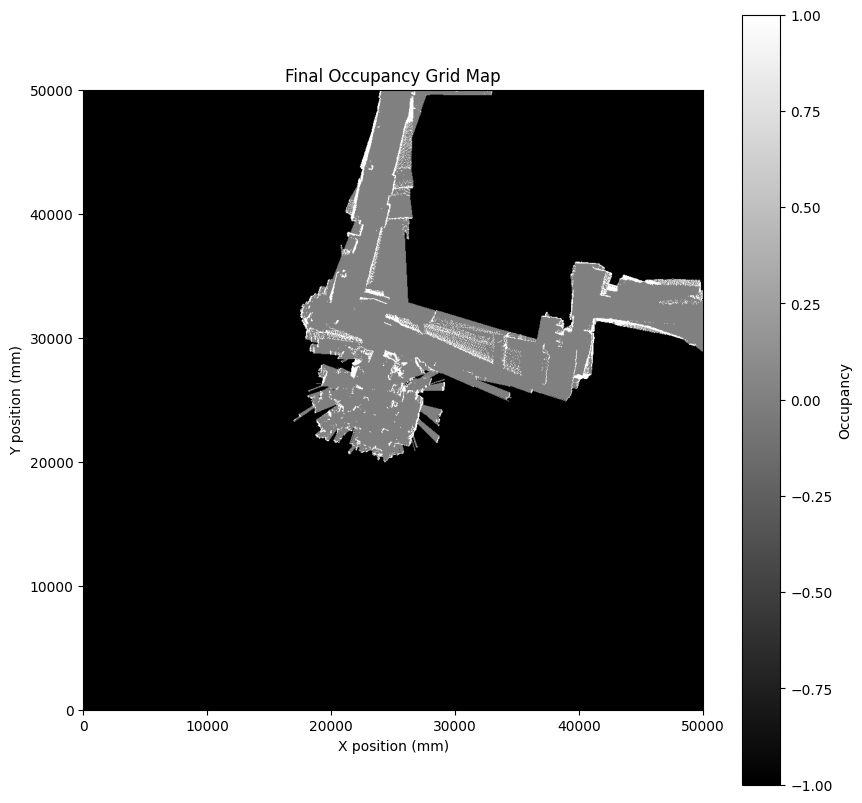

In [28]:
#### CELL 4 ####
# This cell attempts to apply the full SLAM algorithm by the particle filtering system

class Particle:
    def __init__(self, x, y, theta, weight=1.0):
        self.x = x
        self.y = y
        self.theta = theta
        self.weight = weight

def initialize_particles(num_particles, initial_x, initial_y, initial_theta):
    particles = []
    for _ in range(num_particles):
        # Introduce small variations around the initial position and orientation
        x = initial_x + np.random.normal(0, 20)  # 20 mm standard deviation
        y = initial_y + np.random.normal(0, 20)  # 20 mm standard deviation
        theta = initial_theta + np.random.normal(0, theta_noise)  
        particles.append(Particle(x, y, theta))
    return particles


def update_particles_with_odometry(particles, FL, FR, last_FL, last_FR, distance_per_count, wheel_distance):
    for particle in particles:
        delta_FL = (FL - last_FL) * distance_per_count
        delta_FR = (FR - last_FR) * distance_per_count
        delta_theta = (delta_FR - delta_FL) / wheel_distance
        delta_theta_noisy = delta_theta + np.random.normal(0, 0.01)
        
        average_distance = (delta_FL + delta_FR) / 2
        average_distance_noisy = average_distance + np.random.normal(0, 5)
        
        particle.x += average_distance_noisy * np.cos(particle.theta + delta_theta_noisy)
        particle.y += average_distance_noisy * np.sin(particle.theta + delta_theta_noisy)
        particle.theta += delta_theta_noisy
        particle.theta = np.mod(particle.theta + np.pi, 2 * np.pi) - np.pi

def compute_log_likelihood(occupancy_grid, particle, lidar_reading, map_resolution_mm):
    log_likelihood = 0.0
    for angle, distance in zip(lidar_reading['angle'], lidar_reading['scan']):
        if distance > 0:
            hit_x = particle.x + distance * np.cos(particle.theta + angle)
            hit_y = particle.y + distance * np.sin(particle.theta + angle)
            cell_x = int(hit_x // map_resolution_mm)
            cell_y = int(hit_y // map_resolution_mm)
            if 0 <= cell_x < occupancy_grid.shape[0] and 0 <= cell_y < occupancy_grid.shape[1]:
                cell_value = occupancy_grid[cell_y, cell_x]
                if cell_value > 0:  # Occupied
                    log_likelihood += np.log(1.2) * (cell_value / 10)
                elif cell_value < 0:  # Free
                    log_likelihood += np.log(0.8) * (np.abs(cell_value) / 10)
    return log_likelihood

def update_particle_weights(particles, lidar_data, occupancy_grid, map_resolution_mm):
    for particle in particles:
        log_likelihood = compute_log_likelihood(occupancy_grid, particle, lidar_data, map_resolution_mm)
        particle.weight += log_likelihood  # Update in log space

def resample_particles(particles):
    weights = np.array([particle.weight for particle in particles])
    max_weight = np.max(weights)
    weights -= max_weight  # Stabilize before exponentiating
    weights = np.exp(weights)
    total_weight = np.sum(weights)
    probabilities = weights / total_weight
    indices = np.random.choice(len(particles), size=len(particles), p=probabilities)
    return [copy.deepcopy(particles[i]) for i in indices]


def update_map_with_best_particle(occupancy_grid, best_particle, lidar_reading, map_resolution_mm):
    log_odds_hit = np.log(2)
    # log_odds_miss = np.log(0.5)
    for angle, distance in zip(lidar_reading['angle'], lidar_reading['scan']):
        if distance > 0:
            hit_x_m = best_particle.x + distance * np.cos(best_particle.theta + angle)
            hit_y_m = best_particle.y + distance * np.sin(best_particle.theta + angle)
            hit_x_idx = int(hit_x_m / map_resolution_mm)
            hit_y_idx = int(hit_y_m / map_resolution_mm)
            if 0 <= hit_x_idx < occupancy_grid.shape[1] and 0 <= hit_y_idx < occupancy_grid.shape[0]:
                occupancy_grid[hit_y_idx, hit_x_idx] += log_odds_hit
                np.clip(occupancy_grid, -10, 10, out=occupancy_grid)  # Ensuring values are within bounds



# SLAM Loop

# Constants and initializations
num_particles = 50
theta_noise = np.radians(1)
initial_x, initial_y, initial_theta = 25000, 25000, 0  # Replace these with your actual initial values if different
particles = initialize_particles(num_particles, initial_x, initial_y, initial_theta)
map_resolution_mm = 50

debug_start_time_step = 0  # Start from the first timestep
debug_end_time_step = 10 # Specify the last timestep you want to process

# SLAM Loop
for t in range(debug_start_time_step, min(debug_end_time_step, len(encoder_ts))):
    FL_current, FR_current = FL[t], FR[t]
    last_FL, last_FR = FL[t-1], FR[t-1]

    # Update particles with odometry
    update_particles_with_odometry(particles, FL_current, FR_current, last_FL, last_FR, distance_per_count_mm, distance_between_wheels_mm)

    # Process lidar_data only if within the specified range
    if t < len(lidar_data):
        update_particle_weights(particles, lidar_data[t], occupancy_grid, map_resolution_mm)
    
    particles = resample_particles(particles)
    best_particle = max(particles, key=lambda p: p.weight)
    update_map_with_best_particle(occupancy_grid, best_particle, lidar_data[t], map_resolution_mm)

# Final visualization as you've already defined it
plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid.T, cmap='gray', extent=[0, occupancy_grid.shape[1] * map_resolution_mm, 0, occupancy_grid.shape[0] * map_resolution_mm], origin='lower')
plt.colorbar(label='Occupancy')
plt.title('Final Occupancy Grid Map')
plt.xlabel('X position (mm)')
plt.ylabel('Y position (mm)')
plt.show()




# **Map 23**

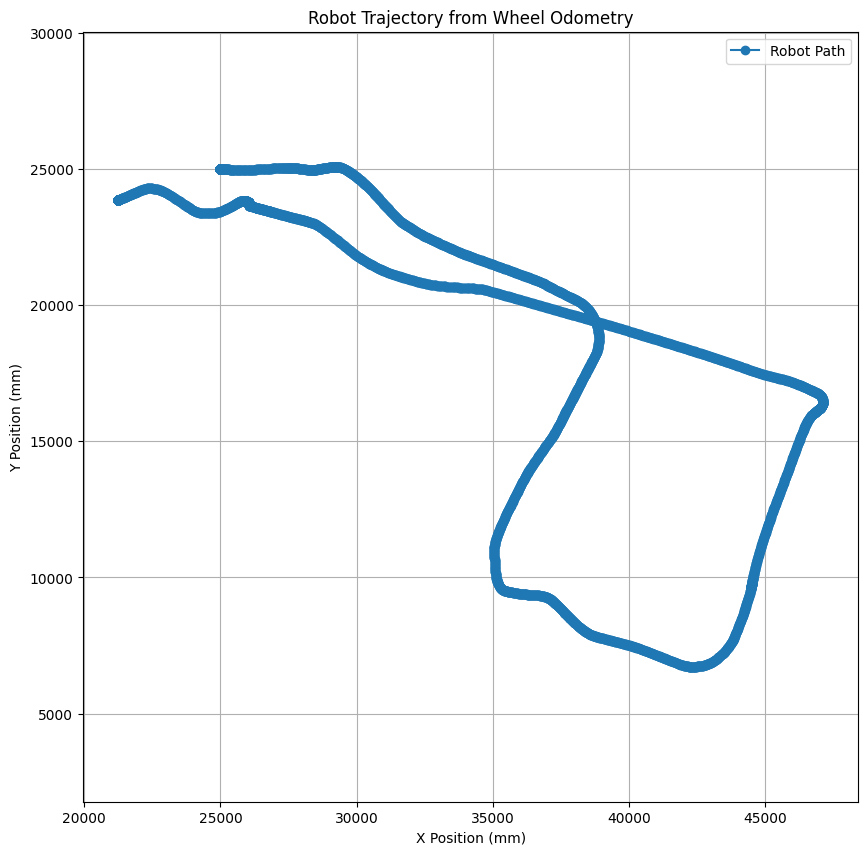

In [29]:
#### CELL 5 ####
# This cell is focused on tracing the path of the robot using pure wheel odometry measurements.

#IMPORTANT TO CHANGE
#change the working directory to where the data folder is
data_directory = '/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project3/ECE5242Proj3-train/data'

FL, FR, RL, RR, encoder_ts = get_encoder(data_directory + '/Encoders23') #Change this to /Encoders20 or /Encoders23 to see different maps

# Constants 
wheel_diameter_mm = 254
distance_between_wheels_mm = 710 # 311.15 * 2.28
encoder_counts_per_rev = 360

# Calculate the distance per count for the encoders
distance_per_count_mm = (np.pi * wheel_diameter_mm) / encoder_counts_per_rev

# Initialize the robot's position and orientation
x_position_mm = 25000
y_position_mm = 25000
theta_radians = 0

# Lists for storing the trajectory
x_trajectory = [x_position_mm]
y_trajectory = [y_position_mm]
theta_radians_list = [theta_radians]


# Loop through encoder timestamps and calculate the robot's trajectory
for i in range(1, len(encoder_ts)):
    
    # Use left and right encoder counts to calculate distance traveled and change in orientation
    delta_FL = (FL[i]) * distance_per_count_mm
    delta_FR = (FR[i]) * distance_per_count_mm
    
    # Update the robot's orientation
    delta_theta = (delta_FR - delta_FL) / distance_between_wheels_mm
    theta_radians += delta_theta
    
    # Ensure theta is within the correct range
    theta_radians = np.mod(theta_radians + np.pi, 2 * np.pi) - np.pi
    
    # Compute the average distance traveled and update the position
    average_distance_mm = (delta_FL + delta_FR) / 2
    x_position_mm += average_distance_mm * np.cos(theta_radians)
    y_position_mm += average_distance_mm * np.sin(theta_radians)
    
    # Add the new position to the trajectory lists
    x_trajectory.append(x_position_mm)
    y_trajectory.append(y_position_mm)
    theta_radians_list.append(theta_radians)


plt.figure(figsize=(10, 10))
plt.plot(x_trajectory, y_trajectory, label='Robot Path', marker='o')
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Robot Trajectory from Wheel Odometry')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


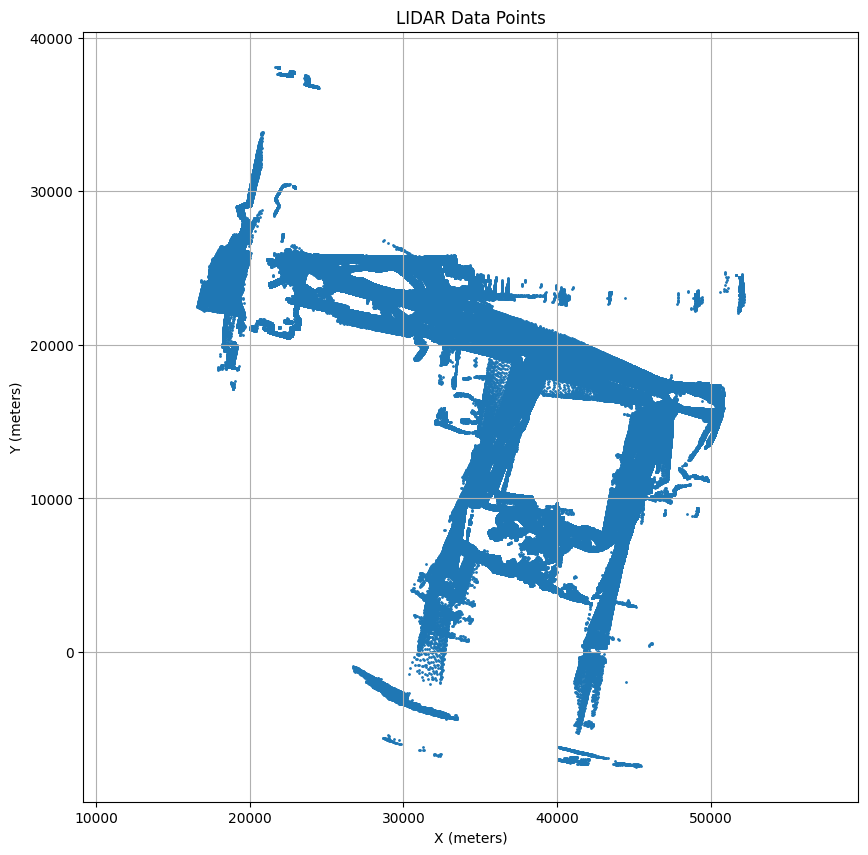

In [30]:
#### CELL 6 ####
# This cell is to scatter plot all the LIDAR Data Points in a 2D map

#IMPORTANT TO CHANGE
#change the last string to be either '/Hokuyo20' or '/Hokuyo23'
lidar_data = get_lidar(data_directory + '/Hokuyo23')

x_points = []
y_points = []


for idx, reading in enumerate(lidar_data):
    if idx >= len(x_trajectory):
        break
    angles = reading['angle']
    distances = reading['scan']
    robot_x = x_trajectory[idx]
    robot_y = y_trajectory[idx]
    robot_theta = theta_radians_list[idx]

    for angle, distance in zip(angles, distances):
        if 0 < (distance * 1000): 
            x = (distance * 1000) * np.cos(angle + robot_theta) + robot_x
            y = (distance * 1000) * np.sin(angle + robot_theta) + robot_y
            x_points.append(x)
            y_points.append(y)

plt.figure(figsize=(10, 10))
plt.scatter(x_points, y_points, s=1)  # s is the size of the points
plt.axis('equal')
plt.grid(True)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('LIDAR Data Points')
plt.show()


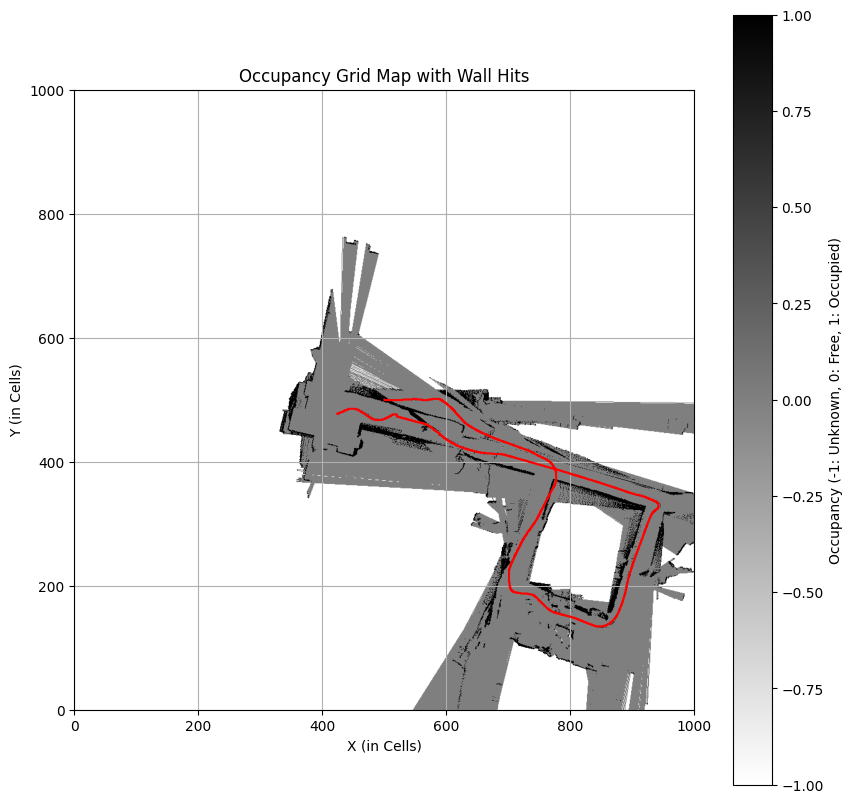

In [31]:
#### CELL 7 ####
# This cell plots the occupancy grid map and marks what are the walls, free space and unknown in the indoor environment 


FREE_SPACE = 0
OCCUPIED_SPACE = 1
UNKNOWN_SPACE = -1

max_distance_mm = 50000
map_resolution_mm = 50
maxMap = int(max_distance_mm / map_resolution_mm) #cells

occupancy_grid = np.full((maxMap, maxMap), UNKNOWN_SPACE)  

debug_start_time_step = 0
debug_end_time_step = 4200


for idx, reading in enumerate(lidar_data[:]):
    idx += debug_start_time_step

    if idx >= len(x_trajectory):
        break

    angles = reading['angle']
    distances = reading['scan'].reshape(-1)

    robot_x_cell = int(x_trajectory[idx] // map_resolution_mm)  # Convert from mm to cells
    robot_y_cell = int(y_trajectory[idx] // map_resolution_mm) # Convert from mm to cells
    robot_theta = theta_radians_list[idx] #radians

    # Convert from polar to Cartesian coordinates
    for angle, distance in zip(angles, distances):
        if 0 < distance:  # Only consider positive distances
            # Transform the LIDAR points from polar coordinates (distance, angle) to Cartesian (x, y)
            wall_x_mm = distance * 1000 * np.cos(angle + robot_theta)  # Convert distance to mm and apply rotation
            wall_y_mm = distance * 1000 * np.sin(angle + robot_theta)  # Convert distance to mm and apply rotation

            # Convert from mm to cells
            wall_x_cell = int((robot_x_cell * map_resolution_mm + wall_x_mm) // map_resolution_mm)
            wall_y_cell = int((robot_y_cell * map_resolution_mm + wall_y_mm) // map_resolution_mm)

            wall_x_cells = np.array([wall_x_cell], dtype=np.int16)
            wall_y_cells = np.array([wall_y_cell], dtype=np.int16)

            # This is to use the python script version
            # ray_cells = getMapCellsFromRay(robot_x_cell, robot_y_cell, wall_x_cells, wall_y_cells, maxMap)

            # This is to use the cython version
            ray_cells = getMapCellsFromRay_fclad(robot_x_cell, robot_y_cell, wall_x_cells, wall_y_cells, maxMap)

            ray_cells = ray_cells.astype(int)

            # print("ray_cells contents:", ray_cells)
            # print("ray_cells types:", ray_cells.dtype)

            for x, y in zip(ray_cells[0], ray_cells[1]):
                if 0 <= x < maxMap and 0 <= y < maxMap:
                    occupancy_grid[int(y), int(x)] = FREE_SPACE

            # Mark the cell as a wall if it's within the grid bounds
            if 0 <= wall_x_cell < maxMap and 0 <= wall_y_cell < maxMap:
                occupancy_grid[wall_y_cell, wall_x_cell] = OCCUPIED_SPACE


x_trajectory_cells = np.array(x_trajectory) // map_resolution_mm
y_trajectory_cells = np.array(y_trajectory) // map_resolution_mm

# Plot the LIDAR end points
plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid, cmap='gray_r', origin='lower', extent=[0, maxMap, 0, maxMap])
plt.colorbar(label='Occupancy (-1: Unknown, 0: Free, 1: Occupied)')

# Overlay the trajectory on the occupancy grid 
plt.plot(x_trajectory_cells, y_trajectory_cells, 'r', label='Robot Path') 

plt.xlabel('X (in Cells)')
plt.ylabel('Y (in Cells)')
plt.title('Occupancy Grid Map with Wall Hits')
plt.grid(True)
plt.show()



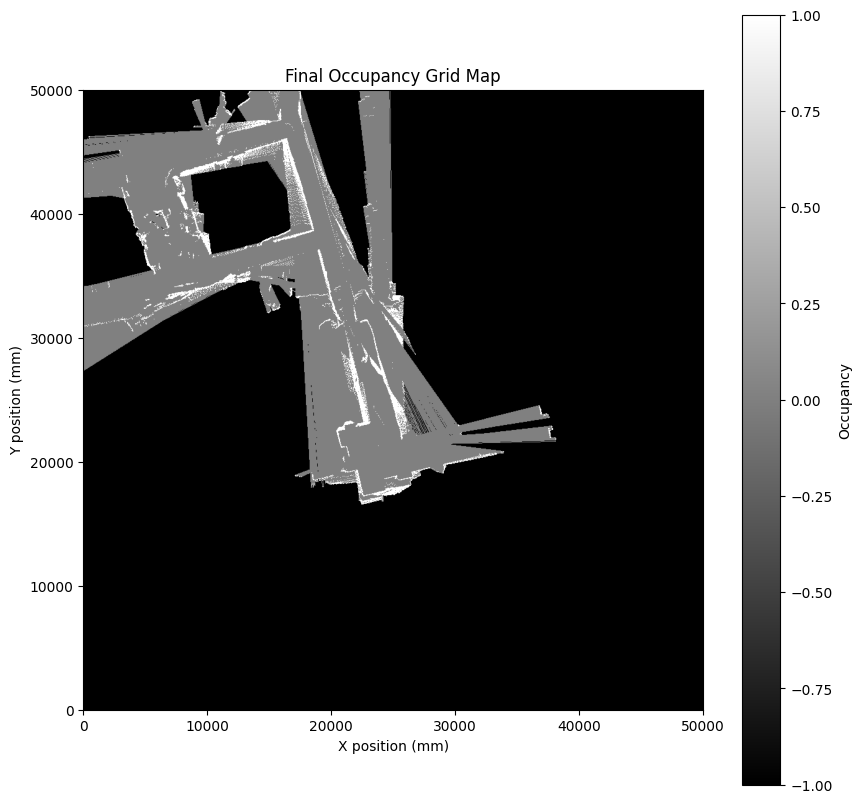

In [32]:
#### CELL 8 ####
# This cell attempts to apply the full SLAM algorithm by the particle filtering system

class Particle:
    def __init__(self, x, y, theta, weight=1.0):
        self.x = x
        self.y = y
        self.theta = theta
        self.weight = weight

def initialize_particles(num_particles, initial_x, initial_y, initial_theta):
    particles = []
    for _ in range(num_particles):
        # Introduce small variations around the initial position and orientation
        x = initial_x + np.random.normal(0, 20)  # 20 mm standard deviation
        y = initial_y + np.random.normal(0, 20)  # 20 mm standard deviation
        theta = initial_theta + np.random.normal(0, theta_noise)  
        particles.append(Particle(x, y, theta))
    return particles


def update_particles_with_odometry(particles, FL, FR, last_FL, last_FR, distance_per_count, wheel_distance):
    for particle in particles:
        delta_FL = (FL - last_FL) * distance_per_count
        delta_FR = (FR - last_FR) * distance_per_count
        delta_theta = (delta_FR - delta_FL) / wheel_distance
        delta_theta_noisy = delta_theta + np.random.normal(0, 0.01)
        
        average_distance = (delta_FL + delta_FR) / 2
        average_distance_noisy = average_distance + np.random.normal(0, 5)
        
        particle.x += average_distance_noisy * np.cos(particle.theta + delta_theta_noisy)
        particle.y += average_distance_noisy * np.sin(particle.theta + delta_theta_noisy)
        particle.theta += delta_theta_noisy
        particle.theta = np.mod(particle.theta + np.pi, 2 * np.pi) - np.pi

def compute_log_likelihood(occupancy_grid, particle, lidar_reading, map_resolution_mm):
    log_likelihood = 0.0
    for angle, distance in zip(lidar_reading['angle'], lidar_reading['scan']):
        if distance > 0:
            hit_x = particle.x + distance * np.cos(particle.theta + angle)
            hit_y = particle.y + distance * np.sin(particle.theta + angle)
            cell_x = int(hit_x // map_resolution_mm)
            cell_y = int(hit_y // map_resolution_mm)
            if 0 <= cell_x < occupancy_grid.shape[0] and 0 <= cell_y < occupancy_grid.shape[1]:
                cell_value = occupancy_grid[cell_y, cell_x]
                if cell_value > 0:  # Occupied
                    log_likelihood += np.log(1.2) * (cell_value / 10)
                elif cell_value < 0:  # Free
                    log_likelihood += np.log(0.8) * (np.abs(cell_value) / 10)
    return log_likelihood

def update_particle_weights(particles, lidar_data, occupancy_grid, map_resolution_mm):
    for particle in particles:
        log_likelihood = compute_log_likelihood(occupancy_grid, particle, lidar_data, map_resolution_mm)
        particle.weight += log_likelihood  # Update in log space

def resample_particles(particles):
    weights = np.array([particle.weight for particle in particles])
    max_weight = np.max(weights)
    weights -= max_weight  # Stabilize before exponentiating
    weights = np.exp(weights)
    total_weight = np.sum(weights)
    probabilities = weights / total_weight
    indices = np.random.choice(len(particles), size=len(particles), p=probabilities)
    return [copy.deepcopy(particles[i]) for i in indices]


def update_map_with_best_particle(occupancy_grid, best_particle, lidar_reading, map_resolution_mm):
    log_odds_hit = np.log(2)
    # log_odds_miss = np.log(0.5)
    for angle, distance in zip(lidar_reading['angle'], lidar_reading['scan']):
        if distance > 0:
            hit_x_m = best_particle.x + distance * np.cos(best_particle.theta + angle)
            hit_y_m = best_particle.y + distance * np.sin(best_particle.theta + angle)
            hit_x_idx = int(hit_x_m / map_resolution_mm)
            hit_y_idx = int(hit_y_m / map_resolution_mm)
            if 0 <= hit_x_idx < occupancy_grid.shape[1] and 0 <= hit_y_idx < occupancy_grid.shape[0]:
                occupancy_grid[hit_y_idx, hit_x_idx] += log_odds_hit
                np.clip(occupancy_grid, -10, 10, out=occupancy_grid)  # Ensuring values are within bounds



# SLAM Loop

# Constants and initializations
num_particles = 50
theta_noise = np.radians(1)
initial_x, initial_y, initial_theta = 25000, 25000, 0  # Replace these with your actual initial values if different
particles = initialize_particles(num_particles, initial_x, initial_y, initial_theta)
map_resolution_mm = 50

debug_start_time_step = 0  # Start from the first timestep
debug_end_time_step = 10 # Specify the last timestep you want to process

# SLAM Loop
for t in range(debug_start_time_step, min(debug_end_time_step, len(encoder_ts))):
    FL_current, FR_current = FL[t], FR[t]
    last_FL, last_FR = FL[t-1], FR[t-1]

    # Update particles with odometry
    update_particles_with_odometry(particles, FL_current, FR_current, last_FL, last_FR, distance_per_count_mm, distance_between_wheels_mm)

    # Process lidar_data only if within the specified range
    if t < len(lidar_data):
        update_particle_weights(particles, lidar_data[t], occupancy_grid, map_resolution_mm)
    
    particles = resample_particles(particles)
    best_particle = max(particles, key=lambda p: p.weight)
    update_map_with_best_particle(occupancy_grid, best_particle, lidar_data[t], map_resolution_mm)

# Final visualization as you've already defined it
plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid.T, cmap='gray', extent=[0, occupancy_grid.shape[1] * map_resolution_mm, 0, occupancy_grid.shape[0] * map_resolution_mm], origin='lower')
plt.colorbar(label='Occupancy')
plt.title('Final Occupancy Grid Map')
plt.xlabel('X position (mm)')
plt.ylabel('Y position (mm)')
plt.show()




# **Test Data**

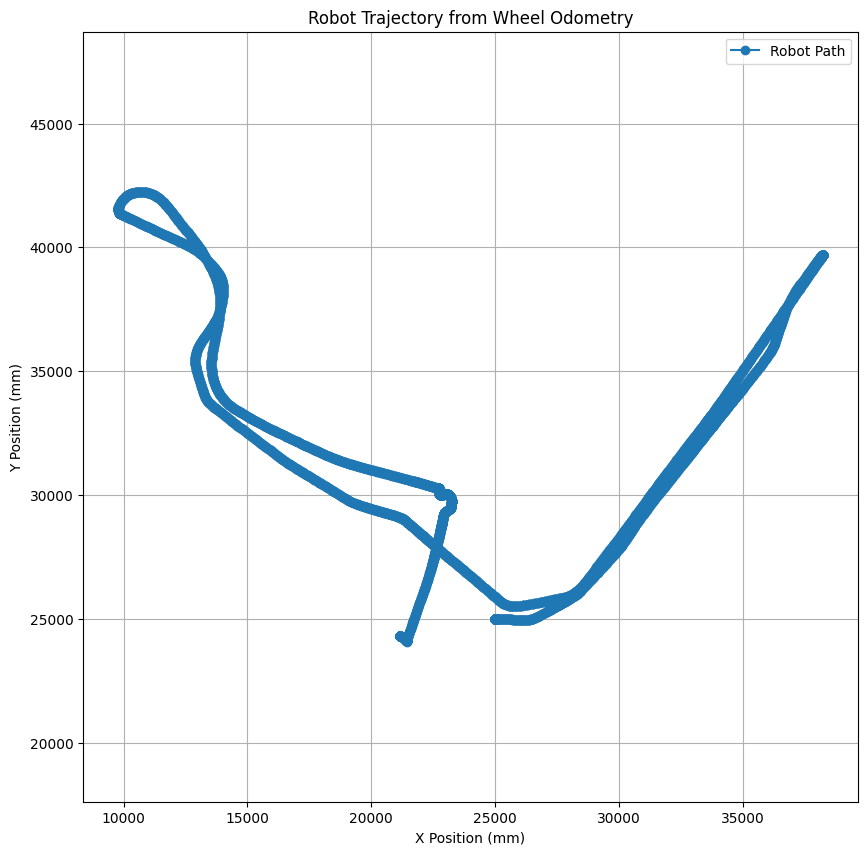

In [45]:
#### CELL 9 ####

#IMPORTANT TO CHANGE
#change the working directory to where the data folder is
data_directory = '/Volumes/Sargart/CornellTechWork/IntelAutoSys/Project3/ECE5242Proj3-test'

FL, FR, RL, RR, encoder_ts = get_encoder(data_directory + '/Encoders22') #Change this to /Encoders20 or /Encoders24 to see different maps
# FL, FR, RL, RR, encoder_ts = get_encoder(data_directory + '/Encoders24')

# Constants 
wheel_diameter_mm = 254
distance_between_wheels_mm = 710 # 311.15 * 2.28
encoder_counts_per_rev = 360

# Calculate the distance per count for the encoders
distance_per_count_mm = (np.pi * wheel_diameter_mm) / encoder_counts_per_rev

# Initialize the robot's position and orientation
x_position_mm = 25000
y_position_mm = 25000
theta_radians = 0

# Lists for storing the trajectory
x_trajectory = [x_position_mm]
y_trajectory = [y_position_mm]
theta_radians_list = [theta_radians]


# Loop through encoder timestamps and calculate the robot's trajectory
for i in range(1, len(encoder_ts)):
    
    # Use left and right encoder counts to calculate distance traveled and change in orientation
    delta_FL = (FL[i]) * distance_per_count_mm
    delta_FR = (FR[i]) * distance_per_count_mm
    
    # Update the robot's orientation
    delta_theta = (delta_FR - delta_FL) / distance_between_wheels_mm
    theta_radians += delta_theta
    
    # Ensure theta is within the correct range
    # theta_radians = np.mod(theta_radians + np.pi, 2 * np.pi) - np.pi
    
    # Compute the average distance traveled and update the position
    average_distance_mm = (delta_FL + delta_FR) / 2
    x_position_mm += average_distance_mm * np.cos(theta_radians)
    y_position_mm += average_distance_mm * np.sin(theta_radians)
    
    # Add the new position to the trajectory lists
    x_trajectory.append(x_position_mm)
    y_trajectory.append(y_position_mm)
    theta_radians_list.append(theta_radians)


plt.figure(figsize=(10, 10))
plt.plot(x_trajectory, y_trajectory, label='Robot Path', marker='o')
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Robot Trajectory from Wheel Odometry')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


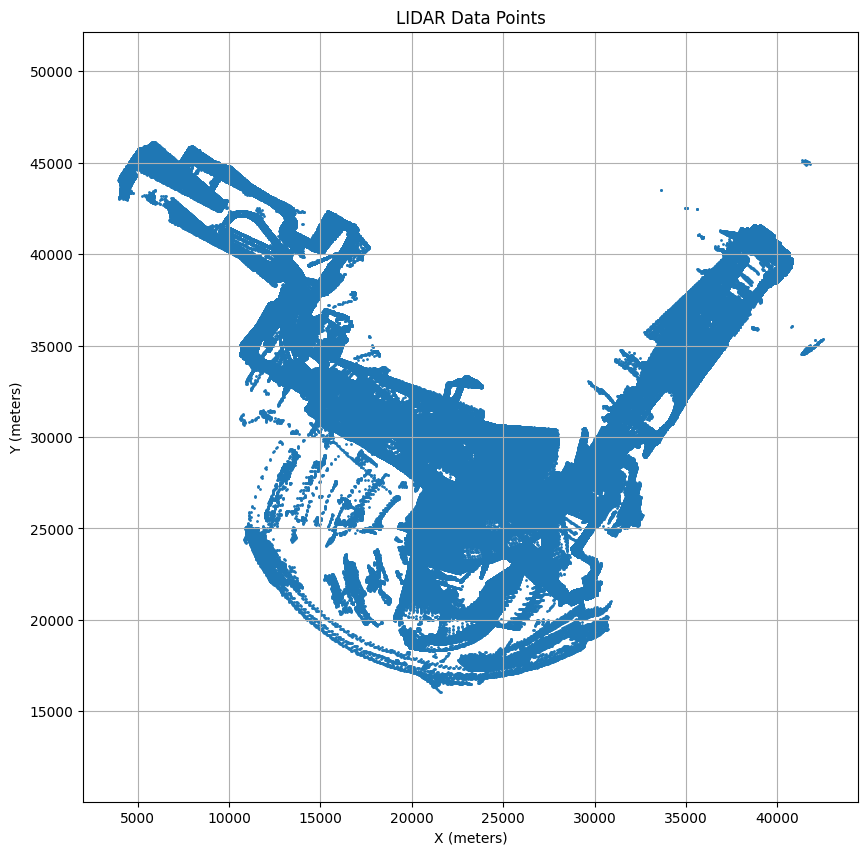

In [48]:
#### CELL 10 ####

#IMPORTANT TO CHANGE
#change the last string to be either '/Hokuyo22' or '/Hokuyo24'
lidar_data = get_lidar(data_directory + '/Hokuyo22')
# lidar_data = get_lidar(data_directory + '/Hokuyo24')

x_points = []
y_points = []


for idx, reading in enumerate(lidar_data):
    if idx >= len(x_trajectory):
        break
    angles = reading['angle']
    distances = reading['scan']
    robot_x = x_trajectory[idx]
    robot_y = y_trajectory[idx]
    robot_theta = theta_radians_list[idx]

    for angle, distance in zip(angles, distances):
        if 0 < (distance * 1000): 
            x = (distance * 1000) * np.cos(angle + robot_theta) + robot_x
            y = (distance * 1000) * np.sin(angle + robot_theta) + robot_y
            x_points.append(x)
            y_points.append(y)

plt.figure(figsize=(10, 10))
plt.scatter(x_points, y_points, s=1)  # s is the size of the points
plt.axis('equal')
plt.grid(True)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('LIDAR Data Points')
plt.show()


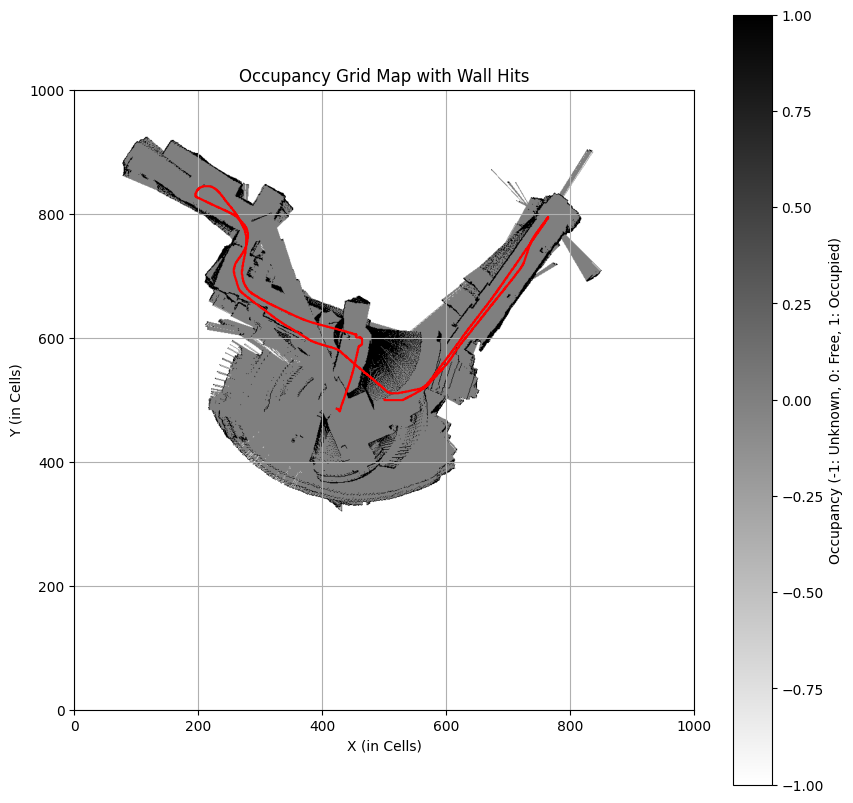

In [49]:
#### CELL 11 ####
# This cell plots the occupancy grid map and marks what are the walls, free space and unknown in the indoor environment 


FREE_SPACE = 0
OCCUPIED_SPACE = 1
UNKNOWN_SPACE = -1

max_distance_mm = 50000
map_resolution_mm = 50
maxMap = int(max_distance_mm / map_resolution_mm) #cells

occupancy_grid = np.full((maxMap, maxMap), UNKNOWN_SPACE)  

debug_start_time_step = 0
debug_end_time_step = 4200


for idx, reading in enumerate(lidar_data[:]):
    idx += debug_start_time_step

    if idx >= len(x_trajectory):
        break

    angles = reading['angle']
    distances = reading['scan'].reshape(-1)

    robot_x_cell = int(x_trajectory[idx] // map_resolution_mm)  # Convert from mm to cells
    robot_y_cell = int(y_trajectory[idx] // map_resolution_mm) # Convert from mm to cells
    robot_theta = theta_radians_list[idx] #radians

    # Convert from polar to Cartesian coordinates
    for angle, distance in zip(angles, distances):
        if 0 < distance:  # Only consider positive distances
            # Transform the LIDAR points from polar coordinates (distance, angle) to Cartesian (x, y)
            wall_x_mm = distance * 1000 * np.cos(angle + robot_theta)  # Convert distance to mm and apply rotation
            wall_y_mm = distance * 1000 * np.sin(angle + robot_theta)  # Convert distance to mm and apply rotation

            # Convert from mm to cells
            wall_x_cell = int((robot_x_cell * map_resolution_mm + wall_x_mm) // map_resolution_mm)
            wall_y_cell = int((robot_y_cell * map_resolution_mm + wall_y_mm) // map_resolution_mm)

            wall_x_cells = np.array([wall_x_cell], dtype=np.int16)
            wall_y_cells = np.array([wall_y_cell], dtype=np.int16)

            # This is to use the python script version
            # ray_cells = getMapCellsFromRay(robot_x_cell, robot_y_cell, wall_x_cells, wall_y_cells, maxMap)

            # This is to use the cython version
            ray_cells = getMapCellsFromRay_fclad(robot_x_cell, robot_y_cell, wall_x_cells, wall_y_cells, maxMap)

            ray_cells = ray_cells.astype(int)

            # print("ray_cells contents:", ray_cells)
            # print("ray_cells types:", ray_cells.dtype)

            for x, y in zip(ray_cells[0], ray_cells[1]):
                if 0 <= x < maxMap and 0 <= y < maxMap:
                    occupancy_grid[int(y), int(x)] = FREE_SPACE

            # Mark the cell as a wall if it's within the grid bounds
            if 0 <= wall_x_cell < maxMap and 0 <= wall_y_cell < maxMap:
                occupancy_grid[wall_y_cell, wall_x_cell] = OCCUPIED_SPACE


x_trajectory_cells = np.array(x_trajectory) // map_resolution_mm
y_trajectory_cells = np.array(y_trajectory) // map_resolution_mm

# Plot the LIDAR end points
plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid, cmap='gray_r', origin='lower', extent=[0, maxMap, 0, maxMap])
plt.colorbar(label='Occupancy (-1: Unknown, 0: Free, 1: Occupied)')

# Overlay the trajectory on the occupancy grid 
plt.plot(x_trajectory_cells, y_trajectory_cells, 'r', label='Robot Path') 

plt.xlabel('X (in Cells)')
plt.ylabel('Y (in Cells)')
plt.title('Occupancy Grid Map with Wall Hits')
plt.grid(True)
plt.show()



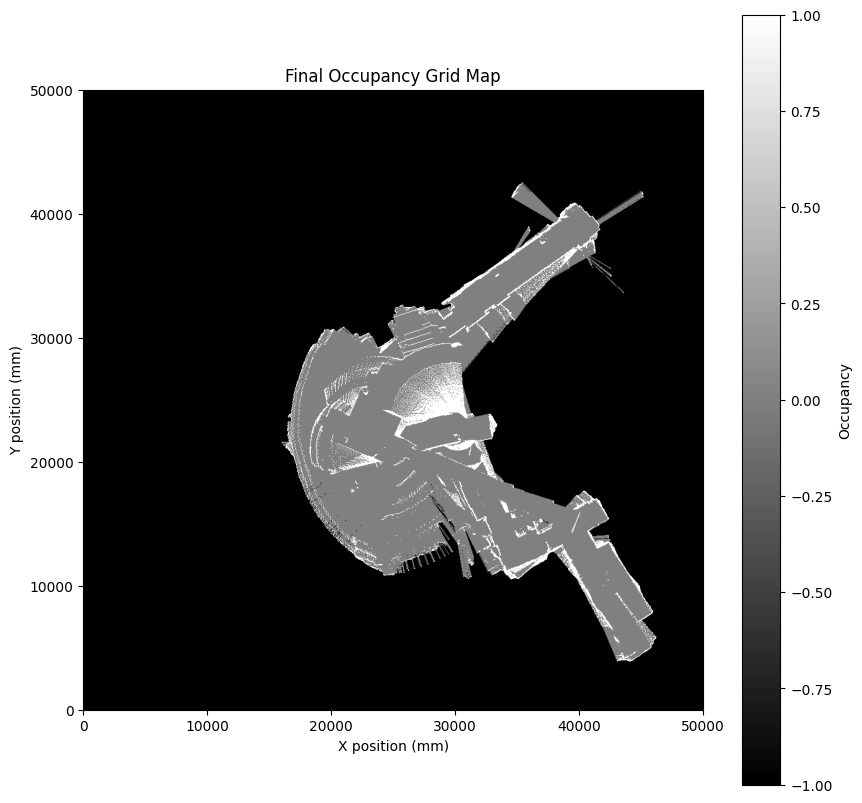

In [50]:
#### CELL 12 ####
# This cell attempts to apply the full SLAM algorithm by the particle filtering system

class Particle:
    def __init__(self, x, y, theta, weight=1.0):
        self.x = x
        self.y = y
        self.theta = theta
        self.weight = weight

def initialize_particles(num_particles, initial_x, initial_y, initial_theta):
    particles = []
    for _ in range(num_particles):
        # Introduce small variations around the initial position and orientation
        x = initial_x + np.random.normal(0, 20)  # 20 mm standard deviation
        y = initial_y + np.random.normal(0, 20)  # 20 mm standard deviation
        theta = initial_theta + np.random.normal(0, theta_noise)  
        particles.append(Particle(x, y, theta))
    return particles


def update_particles_with_odometry(particles, FL, FR, last_FL, last_FR, distance_per_count, wheel_distance):
    for particle in particles:
        delta_FL = (FL - last_FL) * distance_per_count
        delta_FR = (FR - last_FR) * distance_per_count
        delta_theta = (delta_FR - delta_FL) / wheel_distance
        delta_theta_noisy = delta_theta + np.random.normal(0, 0.01)
        
        average_distance = (delta_FL + delta_FR) / 2
        average_distance_noisy = average_distance + np.random.normal(0, 5)
        
        particle.x += average_distance_noisy * np.cos(particle.theta + delta_theta_noisy)
        particle.y += average_distance_noisy * np.sin(particle.theta + delta_theta_noisy)
        particle.theta += delta_theta_noisy
        particle.theta = np.mod(particle.theta + np.pi, 2 * np.pi) - np.pi

def compute_log_likelihood(occupancy_grid, particle, lidar_reading, map_resolution_mm):
    log_likelihood = 0.0
    for angle, distance in zip(lidar_reading['angle'], lidar_reading['scan']):
        if distance > 0:
            hit_x = particle.x + distance * np.cos(particle.theta + angle)
            hit_y = particle.y + distance * np.sin(particle.theta + angle)
            cell_x = int(hit_x // map_resolution_mm)
            cell_y = int(hit_y // map_resolution_mm)
            if 0 <= cell_x < occupancy_grid.shape[0] and 0 <= cell_y < occupancy_grid.shape[1]:
                cell_value = occupancy_grid[cell_y, cell_x]
                if cell_value > 0:  # Occupied
                    log_likelihood += np.log(1.2) * (cell_value / 10)
                elif cell_value < 0:  # Free
                    log_likelihood += np.log(0.8) * (np.abs(cell_value) / 10)
    return log_likelihood

def update_particle_weights(particles, lidar_data, occupancy_grid, map_resolution_mm):
    for particle in particles:
        log_likelihood = compute_log_likelihood(occupancy_grid, particle, lidar_data, map_resolution_mm)
        particle.weight += log_likelihood  # Update in log space

def resample_particles(particles):
    weights = np.array([particle.weight for particle in particles])
    max_weight = np.max(weights)
    weights -= max_weight  # Stabilize before exponentiating
    weights = np.exp(weights)
    total_weight = np.sum(weights)
    probabilities = weights / total_weight
    indices = np.random.choice(len(particles), size=len(particles), p=probabilities)
    return [copy.deepcopy(particles[i]) for i in indices]


def update_map_with_best_particle(occupancy_grid, best_particle, lidar_reading, map_resolution_mm):
    log_odds_hit = np.log(2)
    # log_odds_miss = np.log(0.5)
    for angle, distance in zip(lidar_reading['angle'], lidar_reading['scan']):
        if distance > 0:
            hit_x_m = best_particle.x + distance * np.cos(best_particle.theta + angle)
            hit_y_m = best_particle.y + distance * np.sin(best_particle.theta + angle)
            hit_x_idx = int(hit_x_m / map_resolution_mm)
            hit_y_idx = int(hit_y_m / map_resolution_mm)
            if 0 <= hit_x_idx < occupancy_grid.shape[1] and 0 <= hit_y_idx < occupancy_grid.shape[0]:
                occupancy_grid[hit_y_idx, hit_x_idx] += log_odds_hit
                np.clip(occupancy_grid, -10, 10, out=occupancy_grid)  # Ensuring values are within bounds



# SLAM Loop

# Constants and initializations
num_particles = 50
theta_noise = np.radians(1)
initial_x, initial_y, initial_theta = 25000, 25000, 0  # Replace these with your actual initial values if different
particles = initialize_particles(num_particles, initial_x, initial_y, initial_theta)
map_resolution_mm = 50

debug_start_time_step = 0  # Start from the first timestep
debug_end_time_step = 10 # Specify the last timestep you want to process

# SLAM Loop
for t in range(debug_start_time_step, min(debug_end_time_step, len(encoder_ts))):
    FL_current, FR_current = FL[t], FR[t]
    last_FL, last_FR = FL[t-1], FR[t-1]

    # Update particles with odometry
    update_particles_with_odometry(particles, FL_current, FR_current, last_FL, last_FR, distance_per_count_mm, distance_between_wheels_mm)

    # Process lidar_data only if within the specified range
    if t < len(lidar_data):
        update_particle_weights(particles, lidar_data[t], occupancy_grid, map_resolution_mm)
    
    particles = resample_particles(particles)
    best_particle = max(particles, key=lambda p: p.weight)
    update_map_with_best_particle(occupancy_grid, best_particle, lidar_data[t], map_resolution_mm)

# Final visualization as you've already defined it
plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid.T, cmap='gray', extent=[0, occupancy_grid.shape[1] * map_resolution_mm, 0, occupancy_grid.shape[0] * map_resolution_mm], origin='lower')
plt.colorbar(label='Occupancy')
plt.title('Final Occupancy Grid Map')
plt.xlabel('X position (mm)')
plt.ylabel('Y position (mm)')
plt.show()


